요약 작업은 인코더-디코더 트랜스포머가 잘 맞다.  
인코더-디코더 모델을 만들어 여러 사람이 주고받는 대화를 간결하게 요약해보자.

In [ ]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 588 (delta 5), reused 3 (delta 1), pack-reused 569
Receiving objects: 100% (588/588), 57.41 MiB | 22.19 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.27.2
Using datasets v2.10.1
Using accelerate v0.17.1
Using sentencepiece v0.1.97
Using sacrebleu v2.3.1
Using rouge_score
Using nltk v3.8.1
Using py7zr v0.20.4


# CNN/DailyMail 데이터셋
CNN/DailyMail 데이터셋은 300000개 뉴스 기사와 요약의 쌍으로 구성된다.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version = "3.0.0")
print(f"특성: {dataset['train'].column_names}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

특성: ['article', 'highlights', 'id']


이 데이터셋은 세 가지 특성이 있다. 뉴스 기사를 담은 article, 요약에 해당하는 highlightsk, 기사의 고유 아이디 id이다. 기사 하나의 내용을 일부 발최해보자.

In [ ]:
sample = dataset['train'][1]
print(f"본문 길이 : {len(sample['article'])}")
print(sample['article'][:500])

print(f"요약본 길이 : {len(sample['highlights'])}")
print(sample['highlights'])

본문 길이 : 4051
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most s
요약본 길이 : 281
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


기사가 요약에 비해 매우 긴 경우가 있다. 대부분 트랜스포머 모델의 문맥 크기가 몇 단락에 해당하는 분량인 1000개 토큰 정도로 제한되므로, 긴 기사는 트랜스포머 모델에 문제를 일으킨다.  

이를 처리하는 표준적이면서도 단순한 방법은 모델의 문맥 크기에 맞춰 텍스트를 자르는 것이다. 텍스트 끝부분에 중요한 정보가 있다면 사라지겠지만, 이는 모델 구조의 제약으로 생기는 불가피한 선택이다.

# 텍스트 요약 파이프라인
앞의 예제 기사에 대한 출력을 정성적으로 살펴보면서 요약 작업에 많이 사용되는 트랜스포머 모델을 몇 가지 알아보자. 살펴볼 모델 구조는 최대 입력 크기가 각각 다르지만, 동일한 입력을 사용하고 출력을 비교하기 위해 입력 텍스트를 2000자로 제한하였다.

In [ ]:
sample_text = dataset['train'][1]['article'][:2000]
#딕셔너리에 각 모델이 생성한 요약을 저장함
summaries = {}

요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눈다. 마침표마다 그 뒤에 줄바꿈 토큰을 추가해도 되지만 그러면 'U.S' 같은 문자열을 처리할 수 없다.  

NLTK(Natural Language Toolkit) 패키지에는 문장의 종결과 약어에 등장하는 구두점을 구별하는 더 정교한 알고리즘이 있다.


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['The U.S. are a country.', 'The U.N. is an organization.']

## 요약 기준 모델
기사를 요약하는 일반적인 기준 모델은 단순히 기사에서 맨 처음 문장 세 개를 선택하는 것이다. 이런 기준 모델은 NLTK 문장 토크나이저로 쉽게 구현 가능하다.

In [ ]:
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

summaries['baseline'] = three_sentence_summary(sample_text)
summaries['baseline']

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'

## GPT-2
GPT-2는 입력 텍스트 뒤에 'TL:DR'을 추가해 요약을 생성하는 놀라운 기능을 발휘한다. "too long: didn't read"라는 문구의 약어 "TL:DR"은 긴 포스트를 짧게 요약할 때 종종 사용된다. 트랜스포머스의 pipeline() 함수로 원본 논문의 방식을 재현하며 요약 작업을 실험해보겠다.  

텍스트 생성 파이프라인을 만들고 대용량 GPT-2 모델을 로드한다.

In [ ]:
from transformers import pipeline, set_seed

set_seed(42)

pipe = pipeline('text-generation', model = 'gpt2-large')
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length = 512, clean_up_tokenization_spaces = True)
summaries['gpt2'] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

#나중의 비교를 위해 출력에서 입력 텍스트의 다음 부분을 요약으로 추출해 파이썬 딕셔너리에 저장한다.

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


## T5

T5 체크포인트는 요약을 포함해 여러 작업에서 비지도 학습 데이터와 지도 학습 데이터를 섞은 데이터로 훈련되었다. 따라서 미세 튜닝 없이 이 체크포인트를 사전 훈련에 썼던 것과 동일한 프롬프트를 사용해 바로 요약에 사용할 수 있다.

문서 요약에 사용할 모델의 입력 포맷은 "summarize: <ARTICLE>"이고, 번역에 사용할 입력 포맷은 "translate English to German: <TEXT>"이다.

요약을 위해 pipeline()함수로 T5를 바로 로드하겠다. 이 함수는 입력을 text-to-text 포맷으로 처리하므로 앞에 "summarize"를 붙일 필요가 없다.

In [ ]:
pipe = pipeline("summarization", model = "t5-large")
pipe_out = pipe(sample_text)
summaries['t5'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## BART

BART도 인코더 - 디코더 구조를 사용하는 모델로, 손상된 입력을 재구성하도록 훈련된다. 이를 위해 BERT와 GPT-2의 사전 훈련 방식을 결합한다. 여기서는 특별히 CNN/DailyMail 데이터셋에 미세 튜닝된 facebook/bart-large-cnn 체크포인트를 사용하겠다.

In [ ]:
pipe = pipeline('summarization', model = 'facebook/bart-large-cnn')
pipe_out = pipe(sample_text)
summaries['bart'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

## PEGASUS

PEGASUS는 BART와 마찬가지로 인코더-디코더 트랜스포머이다. 이 모델은 여러 문장으로 구성된 텍스트에서 마스킹된 문장을 예측하는 사전 훈련 목표로 훈련됐다. 논문의 저자들은 사전 훈련 목표가 후속 작업에 가까울수록 더 효과적이라고 주장한다.  

일반적인 언어 모델링보다 요약에 특화된 사전 훈련 목표를 찾기 위해 대규모 말뭉치에서 주변 문단의 내용을 대부분 담은 문장을 자동으로 식별했다. 이런 문장을 재구성하도록 PEGASUS 모델을 사전 훈련해 최고 수준의 텍스트 요약 모델을 얻었다.

이 모델은 줄바꿈하는 특수 토큰이 있으므로 sent_tokenize() 함수를 사용할 필요가 없다.

In [ ]:
pipe = pipeline('summarization', model = 'google/pegasus-cnn_dailymail')
pipe_out = pipe(sample_text)
summaries['pegasus'] = pipe_out[0]['summary_text'].replace(" .<n>", ".\n")

# 요약 결과 비교하기

각기 다른 네 모델로 요약을 생성했다. GPT는 데이터셋에서 전혀 훈련되지 않았으며, T5는 여러 작업 중의 하나로 이 작업을 위해 미세 튜닝됐다. BART와 PEGASUS는 이 작업만을 위해 미세튜닝됐다. 네 모델이 생성한 요약 결과를 보자.

In [ ]:
print("GROUND TRUTH")
print(dataset['train'][1]['highlights'])
print("")

for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are
mentally ill. An inmate housed on the "forgotten floor," where many mentally ill
inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention
facility is dubbed the "forgotten floor."

GPT2
In our tour we visited a notorious "forgotten floor" in one of the most
high-security jails in the country.
We found thousands of mentally ill people who were jailed for various offenses,
including drug and assault.
Wh

여러 모델중 어떤 모델을 사용할지 결정하는 과정이 필요하다. 이 때, 지표를 하나 정의하고 특정 벤치마크 데이터셋에서 모든 모델을 평가하여 성능이 최고인 모델을 선택하는 것이 이상적이다.

생성된 텍스트의 품질을 측정하기 위해 개발된 지표를 알아보자.

# 생성된 텍스트 품질 평가하기

평가 지표는 모델을 훈련할 때만이 아니라 나중에 제품 환경에서도 모델 성능을 평가하기에 중요하다. 평가 지표가 나쁘면 모델의 성능 저하를 눈치 채지 못하고, 평가 지표가 비즈니스 목표에 맞지 않으면 어떤 가치도 창출하지 못한다.

생성된 텍스트를 평가하는 데 가장 널리 사용되는 두 지표는 BLEU와 ROUGE이다. 어떻게 정의됐는지 알아보자.

## BLEU

BLEU는 생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬됐는지 확인하는 대신, 단어 또는 n-그램을 체크한다. BLEU는 정밀도를 근간으로 하는 지표이다. 

In [ ]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

<ipython-input-12-eacc06f6d0e4>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


bleu_metirc 객체는 Metric 클래스의 인스턴스로 하나의 수집기처럼 작동한다. add() 메서드에 샘플 하나를 추가하거나 add_batch() 메서드로 배치 전체를 추가한다. 평가하려는 샘플을 모두 추가한 후, compute() 메서드를 호출하면 지표가 계산된다.

이 메서드는 몇 개의 값으로 구성된 딕셔너리를 반환한다. 각 n-그램에 대한 정밀도, 길이 페널티, 최종 BLEU 점수 등이다.

In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(prediction = 'the the the the the', reference = ['the cat is on the mat']) #샘플 추가
results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0) #지표 계산
results['precisions'] = [np.round(p, 2) for p in results['precisions']] #np.round(p, 2) : p를 소수점 둘째자리까지 반올림
pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[5, 4, 3, 2]"
precisions,"[40.0, 0.0, 0.0, 0.0]"
bp,0.818731
sys_len,5
ref_len,6


In [ ]:
results['precisions']

[40.0, 0.0, 0.0, 0.0]

실제로 1-그램의 정밀도는 2/6이다. 반면 2/3/4-그램의 정밀도는 모두 0이다. 그러면 기하 평균이 0이 되므로 BLEU 점수도 0이 된다. 정밀도가 매우 높은 또 다른 예시를 보자.

In [ ]:
bleu_metric.add(prediction = 'the cat is on mat', reference = ['the cat is on the mat']) #샘플 추가
results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0) #지표 계산
results['precisions'] = [np.round(p, 2) for p in results['precisions']]
pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


정밀도 점수가 훨씬 좋아졌다. 두 번째를 맞추지 못했으므로 4-그램 정밀도는 0.5가 된다.  

BLEU 점수는 텍스트 평가에 널리 사용도니다. 가능하고 적합한 단어를 모두 포함하는 번역보다 정확한 번역이 선호되기 때문에 특히 기계 번역에 많이 쓰인다.

이와 상황이 다른 요약 같은 어플리케이션이 있다. 이 때는 중요한 저오가 생성된 텍스트에 모두 포함되야 하므로 높은 재현율이 선호된다. 이런 작업은 주로 ROUGE가 사용된다.

# ROUGE

ROUGE 점수는 높은 재현율이 정밀도보다 훨씬 더 중요한 요약 같은 어플리케이션을 위해 특별히 개발되었다.

In [ ]:
rouge_metric = load_metric('rouge') #측정 지표 rouge를 로드해서 rouge_metric에 저장

reference = dataset['train'][1]['highlights']
records = []
rouge_names = ['rouge1','rouge2','rougeL','rougeLsum']

for model_name in summaries:
  rouge_metric.add(prediction = summaries[model_name], reference = reference)
  score = rouge_metric.compute()  #rouge를 로드한 지표에 계산
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rough_names)
  records.append(rouge_dict)

pd.DataFrame.from_records(records, index = summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.290909,0.055556,0.181818,0.272727
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


# CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

이제 모델을 적절히 평가할 요소를 모두 갖추었다. CNN/DailyMail의 테스트 세트, ROUGE 지표, 요약 모델이 준비됐으니, 서로 연결만 하면 된다. 처음 세 문장을 사용하는 기준 모델의 성능부터 평가해보자.

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

계산을 비교적 빠르게 하기 위해 테스트 세트에서 1000개를 샘플링해 평가하겠다.

In [ ]:
test_sampled = dataset['test'].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient = 'index', columns = ["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


이전 결과보다는 낮지만, GPT-2보다 좋은 성능을 보인다. 이제 PEGASUS 모델을 평가할 함수를 구현해보자.

In [ ]:
def exercise():
  for i in range(10):
    yield i

list(exercise())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
def exercise():
  for i in range(10):
    return i
exercise()

0

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    #데이터셋을 동시에 처리하기 위해 작은 배치로 나눔
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        #각 배치의 입력 샘플을 토큰화
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        #generate() 함수에 전달해 빔 서치로 요약
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128) #길이 페널티 매개변수로 모델이 매우 긴 시퀀스를 생성하지 않도록 함
        
        #텍스트를 디코딩하고, <n> 토큰을 공백으로 바꾸고, 디코딩된 토큰과 참조 텍스트를 지표에 추가한다.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])



  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:14<30:10, 14.60s/it]

  2%|▏         | 2/125 [00:24<24:13, 11.82s/it]

  2%|▏         | 3/125 [00:35<23:24, 11.51s/it]

  3%|▎         | 4/125 [00:46<23:01, 11.42s/it]

  4%|▍         | 5/125 [00:58<22:44, 11.37s/it]

  5%|▍         | 6/125 [01:09<22:29, 11.34s/it]

  6%|▌         | 7/125 [01:20<22:18, 11.34s/it]

  6%|▋         | 8/125 [01:32<22:14, 11.41s/it]

  7%|▋         | 9/125 [01:44<22:14, 11.50s/it]

  8%|▊         | 10/125 [01:55<22:16, 11.62s/it]

  9%|▉         | 11/125 [02:07<21:48, 11.48s/it]

 10%|▉         | 12/125 [02:17<21:08, 11.22s/it]

 10%|█         | 13/125 [02:29<21:18, 11.41s/it]

 11%|█         | 14/125 [02:41<21:18, 11.51s/it]

 12%|█▏        | 15/125 [02:53<21:16, 11.61s/it]

 13%|█▎        | 16/125 [03:04<21:06, 11.62s/it]

 14%|█▎        | 17/125 [03:16<20:57, 11.64s/it]

 14%|█▍        | 18/125 [03:28<20:47, 11.66s/it]

 15%|█▌        | 19/125 [03:39<20:34, 11.64s/it]

 16%|█▌        |

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


이 수치는 논문 결과에 매우 근접하다. 여기서 손실과 각 토큰의 정확도가 ROUGE 점수와 일정 수준 관련성이 없다. 손실은 디코딩 전략과 관련이 없지만, ROUGE 점수는 디코딩 전략과 밀접한 관련이 있다.

평가 함수를 마련했으니, 이제 요약을 위한 모델을 직접 훈련해보자.

# 요약 모델 훈련하기

대회와 이에 대한 짧은 요약으로 구성되어있는 데이터셋을 활용한다. 기업에서 이런 대화는 고객과 지원 센터의 상호작용을 나타내기에, 정확한 요약을 생성하면 고객 서비스를 개선하고 고객 요청에 나타난 보편적인 패턴을 감지할 수 있다.
 
데이터에 있는 샘플을 살펴보자.

In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


이 대화는 SMS나 왓치앱에서 주고받은 내용 같다. 미세 튜닝한 모델이 같은 작업을 수행할 수 있을지 알아보자.

## SAMSum에서 PEGASUS 평가하기

먼저 PEGASUS로 요약 파이프라인을 실행해 어떻게 출력되는지 보자. CNN/Daily-Mail 요약 생성 시 사용한 코드를 재사용한다.

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


모델이 대화에서 핵심 문장을 추출해 요약하려는 듯 하다. CNN/DailyMail 데이터셋에는 비교적 잘 맞았지만, SAMSum의 요약은 더 추상적이다. 테스트 세트에서 ROUGE 평가를 수행해 이를 확인해보자.

In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])



  0%|          | 0/103 [00:00<?, ?it/s]

  1%|          | 1/103 [00:11<18:53, 11.11s/it]

  2%|▏         | 2/103 [00:20<16:55, 10.06s/it]

  3%|▎         | 3/103 [00:33<19:04, 11.45s/it]

  4%|▍         | 4/103 [00:45<19:22, 11.74s/it]

  5%|▍         | 5/103 [00:54<17:34, 10.76s/it]

  6%|▌         | 6/103 [01:07<18:14, 11.28s/it]

  7%|▋         | 7/103 [01:19<18:36, 11.63s/it]

  8%|▊         | 8/103 [01:30<18:17, 11.55s/it]

  9%|▊         | 9/103 [01:38<16:23, 10.46s/it]

 10%|▉         | 10/103 [01:50<17:00, 10.97s/it]

 11%|█         | 11/103 [01:59<15:42, 10.24s/it]

 12%|█▏        | 12/103 [02:11<16:23, 10.81s/it]

 13%|█▎        | 13/103 [02:22<16:23, 10.93s/it]

 14%|█▎        | 14/103 [02:34<16:39, 11.23s/it]

 15%|█▍        | 15/103 [02:46<16:40, 11.36s/it]

 16%|█▌        | 16/103 [02:58<16:36, 11.45s/it]

 17%|█▋        | 17/103 [03:09<16:16, 11.36s/it]

 17%|█▋        | 18/103 [03:17<14:49, 10.46s/it]

 18%|█▊        | 19/103 [03:26<14:10, 10.12s/it]

 19%|█▉        |

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


결과가 좋게 나오지는 않았다.  

훈련 전에 평가 파이프라인을 준비하면 두 가지 이점이 있다. 훈련이 성공적인지 바로 평가가 가능해졌고 기준점이 세워진 것이다. 이 데이터셋에서 모델을 미세 튜닝하면 ROUGE 점수가  바로 향상되어야 한다. 그렇지 않으면 훈련 과정에서 문제가 있는 것이다.

 ## PEGASUS 미세 튜닝하기

 훈련을 위해 데이터를 처리하기 전에 입력과 출력 길이의 분포를 간단히 살펴보자.


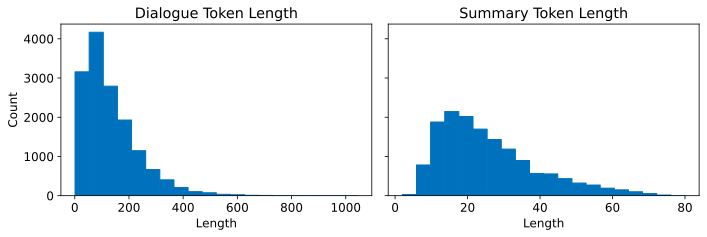

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

대부분 대화는 100 - 200개 토큰으로 구성되며 CNN/DailyMail 기사보다 훨씬 더 짧다. 마찬가지로 요약도 20~40개 토큰(평균 트윗 길이)으로 구성되며 훨씬 더 짧다.  

이런 점을 유념하면서 Trainer를 위한 데이터 콜레이터를 만들겠다. 먼저 데이터셋을 토큰화하자. 여기서는 대화와 요약의 최대 길이를 가각 1024와 128로 설정한다.




In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, #대화 최대 갈이 1024
                                truncation=True)
    
    with tokenizer.as_target_tokenizer(): #with문을 사용하여 토크나이저가 디코더를 위한 토큰화임을 인지하고 그에 따라 시퀀스를 처리할 수 있다.
        target_encodings = tokenizer(example_batch["summary"], max_length=128, #요약 최대 길이 128
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

PEGASUS는 인코더 - 디코더 트랜스포머이고, 따라서 고전적인 seq2seq 구조를 취한다. seq2seq 구조에서는 디코더에 '티처 포싱'을 적용하는 것이 일반적인데, 이 전략에서는 디코더가 인코더 출력 외에 한 토큰이 이동된 레이블로 구성된 입력 토큰을 받는다. 따라서 아래 표처럼 다음 토큰을 위한 예측을 만들 때 디코더는 한 토큰이 이동된 정답을 입력으로 받는다.  

한 스텝 이동했으므로 디코더는 이전 스텝의 정답 레이블만 보며 현재와 미래의 레이블을 보지 못한다.

DataCollectorForSeq2Seq을 통해 배치를 준비할 때 레이블을 한 스텝 오른쪽으로 이동시켜 디코더 입력을 만든다. 이 후 레이블에 있는 패딩 토큰을 -100으로 설정해 손실함수가 무시하도록 한다.

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

이제 이전처럼 훈련을 위해 TrainingArguments를 설정한다.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16) #gradient accumulation : 큰 배치의 gradient를 한 번에 계산하는 대신 작은 배치를 만들고 gradient를 누적하는 방식이다. 충분히 누적되면 최적화 단계가 수행된다.

훈련이 끝난 후 모델을 허브에 저장하기 위해 허깅페이스에 로그인한다.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


이제 Trainer를 초기화하기 위해 필요한 모델, 토크나이저, 훈련 매개변수, 데이터 콜레이터, 훈련 세트, 평가 세트가 모두 준비되었다.

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/cykim/pegasus-samsum into local empty directory.


훈련할 준비가 끝났다. 훈련을 마친 후 테스트 세트로 평가 함수를 실행해 모델의 성능을 확인하자.

In [ ]:
trainer.train()
score = evaluate_summaries_pegasus( #평가함수를 통해 모델 성능 확인
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__ca

{'loss': 3.2499, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.254, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 2.9105, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 3.068, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.9724, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.8728, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.5766, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.2779, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.5841, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.31, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.4969, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.2111, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.19, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1944, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.0608, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 1.9917, 'learning_rat

The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


{'loss': 1.6928, 'learning_rate': 5e-05, 'epoch': 0.54}
{'eval_loss': 1.4812027215957642, 'eval_runtime': 38.907, 'eval_samples_per_second': 21.024, 'eval_steps_per_second': 21.024, 'epoch': 0.54}
{'loss': 1.7443, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 1.6737, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 1.7009, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 1.6908, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 1.6906, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 1.6168, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 1.6116, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 1.622, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 1.6214, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.64}
{'loss': 1.5632, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.65}
{'loss': 1.594, 'learning_rate': 3.690476190476191e-05, 'epoch': 0.66}
{'loss': 1.52



Training completed. Do not forget to share your model on huggingface.co/models =)




{'loss': 1.575, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 2812.1927, 'train_samples_per_second': 5.239, 'train_steps_per_second': 0.327, 'train_loss': 1.8277016971422277, 'epoch': 1.0}


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  6%|▋         | 26/410 [00:49<11:30,  1.80s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  7%|▋         | 27/410 [00:50<11:15,  1.76s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  7%|▋         | 28/410 [00:52<10:59,  1.73s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "m

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.426072,0.197287,0.339313,0.339543


미세 튜닝하지 않은 모델에 비해 ROUGE 점수가 상당히 향상되었다. 이전 모델도 요약에 대해 훈련됐지만 새로운 데이터셋에 잘 적응하지 못하였다. 이 모델을 허브에 조장하자.

In [ ]:
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum/config.json
Configuration saved in pegasus-samsum/generation_config.json
Model weights saved in pegasus-samsum/pytorch_model.bin
tokenizer config file saved in pegasus-samsum/tokenizer_config.json
Special tokens file saved in pegasus-samsum/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file spiece.model:   2%|1         | 32.0k/1.82M [00:00<?, ?B/s]

Upload file runs/Mar14_06-51-19_6489111aa069/1678776987.03511/events.out.tfevents.1678776987.6489111aa069.206.…

Upload file runs/Mar14_06-51-19_6489111aa069/events.out.tfevents.1678776986.6489111aa069.206.0: 100%|#########…

Upload file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/cykim/pegasus-samsum
   b168f76..a6f840b  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/cykim/pegasus-samsum
   b168f76..a6f840b  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'config': 'samsum', 'split': 'validation', 'args': 'samsum'}}
To https://huggingface.co/cykim/pegasus-samsum
   a6f840b..8e30228  main -> main

   a6f840b..8e30228  main -> main



'https://huggingface.co/cykim/pegasus-samsum/commit/a6f840b76a7bc5c4b30a079985a828e6f4026c37'

해당 모델을 사용하여 요약을 몇 개 생성해보자.

대회 요약 생성하기

손실과 ROUGE 점수를 보면 CNN/DailyMail에서만 훈련한 원래 모델보다 크게 향상된 것 같다. 테스트 세트에 있는 샘플로 어떤 요약이 만들어지는지 확인해보자.

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="haesun/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참조 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

모델 요약:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom
helped build a library by Hugging Face. They are going to do it together.
